In [212]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [18]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [204]:
%pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 54.6 MB/s  0:00:12 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 56.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 65.0 MB/s  0:00:08 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 54.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 87.8 MB/s  0:00:019.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 67.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 64.9 MB/s  0:00:09 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 83.4 MB/s  0:00:02 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 71.7 MB/s  0:00:00 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 79.7 MB/s  0:00:03 eta 0:00:010:01:02
   ━━━━━

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data*other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * self.data**(other - 1) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), label='tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [42]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

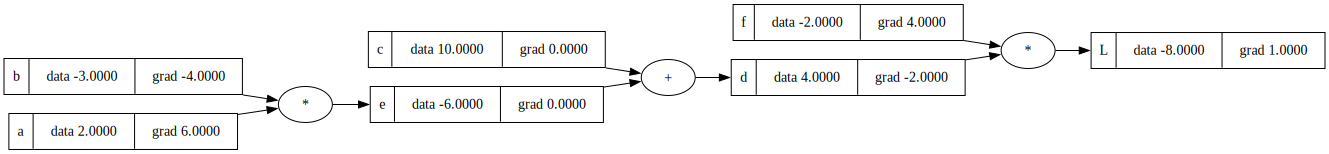

In [56]:
draw_dot(L)

dd/dc ?

d = c + e

(f(x + h) - f(x))/h
((c + h + e) - (c + e))/h
h/h = 1.0

dd/dc = 1.0
dd/de = 1.0

dL/dc ?
dL/dd = -2.0
dd/dc = 1.0

dL/dc = (dL/dd)*(dd/dc) = -2.0
dL/de = (dL/dd)*(dd/de) = -2.0

e = a*b

de/da = b
de/db = a

dL/da = (dL/de)*(de/da)

In [ ]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
a.grad = -2.0*-3.0
b.grad = -2.0*2.0

In [ ]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  d.data += h
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-2.000000000000668


In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813725870195432, label='b')

w1x1 = w1*x1; w1x1.label = 'w1*x1'
w2x2 = w2*x2; w2x2.label = 'w2*x2'
w1x1_w2x2 = w1x1 + w2x2; w1x1_w2x2.label ='w1*x1 + w2*x2' 
n = w1x1_w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [165]:
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = 1 - tanh(n)**2 = 1 - o**2
# n.grad = 1 - o.data**2

# # add node
# b.grad = 0.5
# w1x1_w2x2.grad = 0.5

# # add node
# w1x1.grad = 0.5
# w2x2.grad = 0.5

# # mult nodes
# x1.grad = w1.data * w1x1.grad
# w1.grad = x1.data * w1x1.grad
# x2.grad = w2.data * w2x2.grad
# w2.grad = x2.data * w2x2.grad

## refinement 1

# o.grad = 1.0

# o._backward()
# n._backward()
# b._backward()
# w1x1_w2x2._backward()
# w1x1._backward()
# w2x2._backward()

## refinement 2

# o.grad = 1.0

# topo = []
# visited = set()

# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)

# build_topo(o)

# for node in reversed(topo):
#   node._backward()

## refinement 3

o.backward()

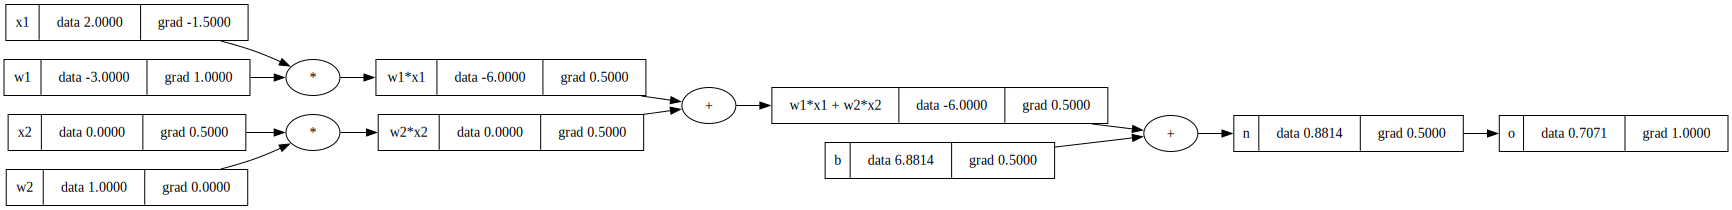

In [166]:
draw_dot(o)

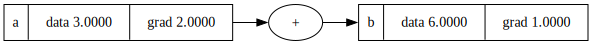

In [168]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()

draw_dot(b)

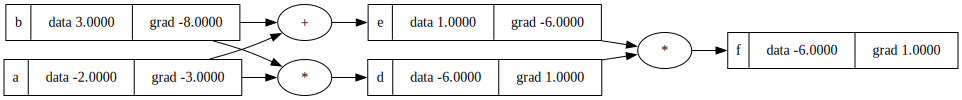

In [169]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label = 'd'
e = a+b; e.label = 'e'
f = d*e; f.label = 'f'

f.backward()

draw_dot(f)

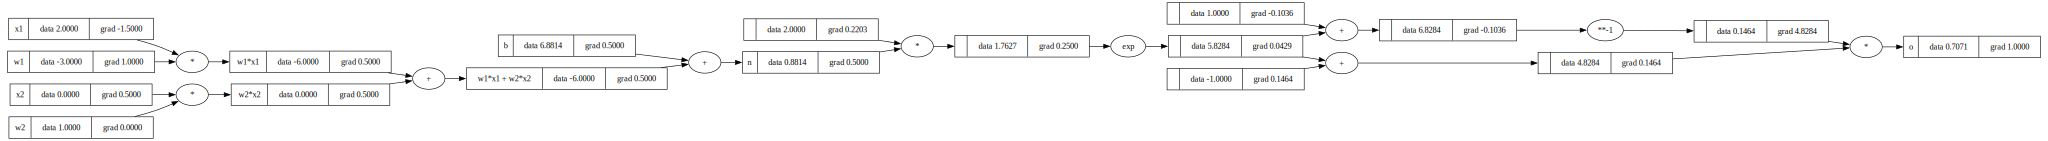

In [201]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813725870195432, label='b')

w1x1 = w1*x1; w1x1.label = 'w1*x1'
w2x2 = w2*x2; w2x2.label = 'w2*x2'
w1x1_w2x2 = w1x1 + w2x2; w1x1_w2x2.label ='w1*x1 + w2*x2' 
n = w1x1_w2x2 + b; n.label = 'n'

e = (2*n).exp()

o = (e - 1)/(e + 1); o.label = 'o'

o.backward()

draw_dot(o)

In [205]:
import torch

In [209]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [207]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813725870195432]).double(); b.requires_grad = True
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('w1', w1.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('x2', x2.grad.item())

0.7071062135674336
---
w1 1.0000016054686538
x1 -1.5000024082029806
w2 0.0
x2 0.5000008027343269


In [314]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

In [284]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.7340300314408931)

In [285]:
n.parameters()

[Value(data=0.013682347143451956),
 Value(data=-0.4402146887197309),
 Value(data=0.35586933481913174)]

In [315]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [287]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.9968360580576601),
 Value(data=0.42148340311011345),
 Value(data=0.9996182688834938)]

In [288]:
n.parameters()

[Value(data=-0.46950999117822345),
 Value(data=-0.4782709350492407),
 Value(data=-0.8499174803191343),
 Value(data=0.26588257396602155),
 Value(data=-0.3048642097307783),
 Value(data=0.8323219910898103),
 Value(data=0.45199804172308533),
 Value(data=0.830616626437686),
 Value(data=0.8860292259789315)]

In [316]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0

In [290]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.2514082338947727)

In [291]:
n.parameters()

[Value(data=0.1658671581193656),
 Value(data=0.4803136326285189),
 Value(data=0.093180853101271),
 Value(data=0.9547381818285408),
 Value(data=0.7039433348438859),
 Value(data=-0.17442220705833233),
 Value(data=-0.021457184014938235),
 Value(data=0.985738156382759),
 Value(data=-0.17066318660422808),
 Value(data=0.8990881571505731),
 Value(data=0.8356179657074074),
 Value(data=0.25848541923774926),
 Value(data=-0.99550199630555),
 Value(data=0.9173083967044766),
 Value(data=-0.7522131249812996),
 Value(data=-0.6344488553095089),
 Value(data=0.143852529873296),
 Value(data=0.4720704768659636),
 Value(data=0.9031331698716938),
 Value(data=-0.01600149787045191),
 Value(data=0.8499520771587941),
 Value(data=-0.6829825182146299),
 Value(data=-0.9645906110413232),
 Value(data=0.8740106676681096),
 Value(data=0.12534588021769966),
 Value(data=0.5630436930628204),
 Value(data=0.3262317608474259),
 Value(data=0.9679894490393259),
 Value(data=-0.4807828253796924),
 Value(data=0.32967070040902025

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

[Value(data=0.2514082338947727),
 Value(data=-0.879687403717954),
 Value(data=-0.4840304255387442),
 Value(data=-0.47459776694775907)]

In [294]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.015527929161717)

In [295]:
loss.backward()

In [296]:
n.layers[0].neurons[0].w[0].grad

0.008298682262576334

In [297]:
n.layers[0].neurons[0].w[0].data

0.1658671581193656

In [298]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [299]:
n.layers[0].neurons[0].w[0].data

0.16578417129673984

In [300]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.413456849251854)

In [310]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6322889264269872)

In [311]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(100):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  n.zero_grad()
  loss.backward()

  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 5.486927831289891
1 3.399238381480418
2 2.4171413452595303
3 1.5821586823180216
4 0.9330160430293941
5 0.5223531124077584
6 0.30740815006580496
7 0.20049326515248592
8 0.1438186017132531
9 0.1106440243335811
10 0.08939476216372684
11 0.07478632956493175
12 0.0641862091704169
13 0.056168185712500235
14 0.04990234931011457
15 0.04487642611482807
16 0.04075845179713865
17 0.03732444310495601
18 0.0344180664942091
19 0.03192702495014751
20 0.029768642349844884
21 0.02788073914346162
22 0.026215672833591355
23 0.024736336901833533
24 0.023413408554497094
25 0.022223414233026307
26 0.021147343460345372
27 0.02016963825601652
28 0.01927744475866277
29 0.018460051111165506
30 0.017708459762094796
31 0.01701505817435374
32 0.016373362535040983
33 0.015777816280572676
34 0.015223630244846333
35 0.014706654742254702
36 0.014223276389066185
37 0.013770334260600769
38 0.013345051288114496
39 0.012944977761079383
40 0.012567944515701188
41 0.012212023927322303
42 0.011875497230861726
43 0.01155682

In [313]:
ypred

[Value(data=0.973766508485669),
 Value(data=-0.9667003991553748),
 Value(data=-0.9588866548969841),
 Value(data=0.9668711753347367)]